In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
from datetime import timedelta

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

## 1. Чтение данных и предобработка ##

In [3]:
customers = pd.read_csv('olist_customers_dataset.csv', encoding='Windows-1251', sep=',') # пользователи
orders = pd.read_csv('olist_orders_dataset.csv', encoding='Windows-1251', sep=',') # заказы
items = pd.read_csv('olist_order_items_dataset.csv', encoding='Windows-1251', sep=',') # товары, входящие в заказы

**Проверим типы данных в df**

In [4]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [5]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Приведем тип данных в некоторых столбцах в формат даты

In [6]:
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [7]:
items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Приведем тип данных в некоторых столбцах в формат даты

In [8]:
items[['shipping_limit_date']] = items[['shipping_limit_date']].apply(pd.to_datetime)
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

**Проверим df на наличие дубликатов**

In [9]:
# Сделаем это с применением функции
def dubl(df):
    if len(df.drop_duplicates()) != len(df):
        print('Обнаружены дубликаты!')
    else:
        print('Дубликтов не обнаружено')

In [10]:
# Проверяем датафрейм customers
dubl(customers)

Дубликтов не обнаружено


In [11]:
# Проверяем датафрейм orders
dubl(orders)

Дубликтов не обнаружено


In [12]:
# Проверяем датафрейм items
dubl(items)

Дубликтов не обнаружено


**Проверим df на наличие пустых ячеек (NaN)**

In [13]:
# Сделаем это с применением функции
def cnt_NaN(df):
    n = df.isna().any(axis=1).sum()
    if n > 0:
        print(f'Обнаружены пустые ячейки в количестве {n}!')
    else:
        print('Пустых ячеек не обнаружено')

In [14]:
# Проверяем датафрейм customers
cnt_NaN(customers)

Пустых ячеек не обнаружено


In [15]:
# Проверяем датафрейм orders
cnt_NaN(orders)

Обнаружены пустые ячейки в количестве 2980!


In [16]:
# Проверяем датафрейм items
cnt_NaN(customers)

Пустых ячеек не обнаружено


Ввиду того, что в датафрейме orders найдены пустые ячейки, то выполним более подробный анализ этого датафрейма. Определим столбцы, в которых найдены пустые значения

In [17]:
# Сделаем это с применением функции
def col_not_NaN(df):
    col_with_NaN = df.columns[df.isna().any()].tolist()
    print(f'Столбцы с пустыми значениями NaN: {', '.join(col_with_NaN)}.')

In [18]:
col_not_NaN(orders)

Столбцы с пустыми значениями NaN: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.


Разберемся, почему в этих столбцах есть пустые ячейки

***olist_orders_dataset.csv*** —  таблица заказов

- *order_id* —  уникальный идентификатор заказа (номер чека);
- *customer_id* —  позаказный идентификатор пользователя;
- *order_status* —  статус заказа;
- *order_purchase_timestamp* —  время создания заказа;
- *order_approved_at* —  время подтверждения оплаты заказа;
- *order_delivered_carrier_date* —  время передачи заказа в логистическую службу;
- *order_delivered_customer_date* —  время доставки заказа;
- *order_estimated_delivery_date* —  обещанная дата доставки;

Исходя из вышеприведенного описания можно сделать вывод, что столбцы *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* могут иметь пустые ячейки. Это можно объяснить тем, что заказ уже создан (есть значение в ячейке столбца *order_purchase_timestamp*), но не подтверждена оплата заказа (ячейка в столбце *order_approved_at*) и (или) не подтверждена передачи заказа в логистическую службу (ячейка в столбце *order_delivered_carrier_date*) и (или) не подтверждена доставка заказа (ячейка в столбце *order_delivered_customer_date*).

**Вывод: наличие пустых ячеек в данных столбцах обосновано**

## 2. Предварительное исследование данных ##

Рассмотрим подробнее данные, которые содержат наши датасеты

***olist_customers_datase.csv*** — таблица с уникальными идентификаторами пользователей
- *customer_id* — позаказный идентификатор пользователя;
- *customer_unique_id* —  уникальный идентификатор пользователя  (аналог номера паспорта);
- *customer_zip_code_prefix* —  почтовый индекс пользователя;
- *customer_city* —  город доставки пользователя;
- *customer_state* —  штат доставки пользователя

***olist_orders_dataset.csv*** —  таблица заказов
- *order_id* —  уникальный идентификатор заказа (номер чека);
- *customer_id* —  позаказный идентификатор пользователя;
- *order_status* —  статус заказа;
- *order_purchase_timestamp* —  время создания заказа;
- *order_approved_at* —  время подтверждения оплаты заказа;
- *order_delivered_carrier_date* —  время передачи заказа в логистическую службу;
- *order_delivered_customer_date* —  время доставки заказа;
- *order_estimated_delivery_date* —  обещанная дата доставки

Уникальные статусы заказов в таблице ***olist_orders_dataset***:
- *created* —  создан
- *approved* —  подтверждён
- *invoiced* —  выставлен счёт
- *processing* —  в процессе сборки заказа
- *shipped* —  отгружен со склада
- *delivered* —  доставлен пользователю 
- *unavailable* —  недоступен
- *canceled* —  отменён

***olist_order_items_dataset.csv*** —  товарные позиции, входящие в заказы
- *order_id* —  уникальный идентификатор заказа (номер чека);
- *order_item_id* —  идентификатор товара внутри одного заказа;
- *product_id* —  ид товара (аналог штрихкода);
-  *seller_id* — ид производителя товара;
- *shipping_limit_date* —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике;
- *price* —  цена за единицу товара;
- *freight_value* —  вес товара

Необходимо понять, что должно считаться покупкой. Рассмотрим как это зависит от фактов оплат, статусов заказов и других имеющихся данных.

Найдем связь **оплата заказа** <--> **факт покупки**

In [19]:
orders.query('order_approved_at == "NaN"')

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\3009319766.py:1: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


В датасете есть **строки без фиксирования времени оплаты заказа**. Рассмотрим это подробнее

In [20]:
# Проверим, при каких статусах заказа не зафиксирована его оплата
orders.query('order_approved_at == "NaN"')['order_status'].unique()

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\1104189098.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



array(['canceled', 'delivered', 'created'], dtype=object)

Со статусами 'created' и 'canceled' все, на первый взгляд, понятно. Заказ может быть создан и не оплачен, также как отменен и не оплачен.

Но нужно разобраться, почему заказ со статусом 'delivered' не оплачен.

In [21]:
# Отфильтруем нужные нам заказы со статусом 'delivered', но без факта оплаты
orders.query('order_status == "delivered" and order_approved_at == "NaN"')

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\3818180301.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Таких заказов всего 14. Такой исход можно получить в некоторых случаях:
- проблемы со стороны банка (нет подтверждения оплаты) - покупка была совершена;
- покупатель не принял товар после его доставки - покупка была совершена

Теперь разберемся со статусами заказов. Рассмотрим как они связаны с имеющимися данными о времени оплаты, передачи в доставку и доставке

In [22]:
# Рассмотрим, при каких статусах заказа зафиксирована оплата заказа
orders.query('order_approved_at != "NaN"')['order_status'].unique()

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\28472486.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'approved'], dtype=object)

Отметим наличие всех статусов, кроме 'created'. Это логично, т.к. сначала заказ создается, затем уже оплачивается. То есть все заказы со статусом 'created' не оплачены.

In [23]:
# Рассмотрим, при каких статусах заказа зафиксирована передача заказа в службу доставки
orders.query('order_delivered_carrier_date != "NaN"')['order_status'].unique()

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\3953695534.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



array(['delivered', 'shipped', 'canceled'], dtype=object)

Отметим наличие таких статусов, как 'delivered', 'shipped', 'canceled'. Т.е. время передачи заказа в службу доставки было зафикисровано только для заказов доставленных, переданных в службу, отмененных (после передачи в службу доставки)

In [24]:
# Рассмотрим, при каких статусах заказа не зафиксирована передача заказа в службу доставки
orders.query('order_delivered_carrier_date == "NaN"')['order_status'].unique()

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\363276169.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

Отметим наличие статуса 'delivered'. Рассмотрим подробнее

In [25]:
orders.query('order_delivered_carrier_date == "NaN" and order_status == "delivered"')

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\3312848519.py:1: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Таких заказов два. Один с зафиксированным временем доставки, другой нет. Вероятно, можем связывать это с нарушениями в работе службы доставки

Также обратим внимание на статус заказа 'unavailable'. Изучим его подробнее

In [26]:
orders.query('order_status == "unavailable"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [27]:
orders.query('order_status == "unavailable"')['order_approved_at'].dropna()

266     2017-11-16 15:26:57
586     2018-01-31 14:23:50
687     2017-08-17 00:15:18
737     2018-01-09 07:26:08
1160    2017-09-28 01:32:50
                ...        
99147   2017-10-19 03:12:43
99233   2017-12-23 18:54:22
99252   2018-01-17 03:37:34
99348   2017-08-28 15:44:47
99415   2017-10-14 18:35:57
Name: order_approved_at, Length: 609, dtype: datetime64[ns]

In [28]:
orders.query('order_status == "unavailable"')['order_delivered_carrier_date'].dropna()

Series([], Name: order_delivered_carrier_date, dtype: datetime64[ns])

In [29]:
orders.query('order_status == "unavailable"')['order_delivered_customer_date'].dropna()

Series([], Name: order_delivered_customer_date, dtype: datetime64[ns])

Видим, что по заказам со статусом 'unavailable' зафиксированы только создание и оплата заказа. Т.е. такие заказы могли быть отменены на стадии сборки из-за отсутствия их у продавца

***Выводы:***
- факт оплаты - не факт покупки;
- вероятны случаи незафиксированной оплаты заказа (из-за ошибки банка, либо возратом после получения);
- факт передачи в службу доставки - статус 'shipped' (либо дальнейшие 'delivered', 'canceled');
- вероятны случаи успешной доставки заказа без фиксации его передачи в службу доставки;
- вероятны случаи отмены заказа со стороны продавца (статус 'unavailable')

## 3. Рассматриваемые вопросы ##

После чтения и предобработки данных можем приступить к дальнейшему анализу данных и получению ответов на следующие вопросы.
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
5. Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.
6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

### 1 вопрос. Сколько у нас пользователей, которые совершили покупку только один раз? ###

In [30]:
# Объединим датафреймы orders и customers
df_1 = orders.merge(customers, how='left', on='customer_id')
df_1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [31]:
# Отбираем нужные нам статусы "processing", "shipped", "delivered" - сборка, отгрузка в доставку, доставка
# Группируем по 'customer_unique_id' - уникальный код пользователя
# Агрегируем по 'order_id' - код заказа
# Отбираем необходимые нам строки с количеством заказов (1)
# Находим общее количество таких пользователей
df_1.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['customer_unique_id'], as_index = False) \
    .agg({'order_id':'count'}) \
    .query('order_id == 1')['customer_unique_id'].count()

np.int64(91814)

In [32]:
# Всего пользователей совершили покупку
df_1.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['customer_unique_id'], as_index = False) \
    .agg({'order_id':'count'})['customer_unique_id'].count()

np.int64(94686)

In [33]:
91814/94686

0.9696681663603912

Отметим очень большое количество таких пользователей. 91814 из 94686 совершивших покупки. Это 97%. Можно полагать, что есть объективные причины, почему пользователи не заказывают товар повторно (т.е. уходят). Разберемся с этим

In [34]:
# Все покупки
df_1_full = orders.query('order_status == ["processing", "shipped", "delivered"]')
df_1_full

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [35]:
df_1_full['processing_time'] = (df_1_full['order_delivered_carrier_date'] - df_1_full['order_purchase_timestamp']) / np.timedelta64 ( 1 , 'D')
df_1_full['delivery_time'] = (df_1_full['order_delivered_customer_date'] - df_1_full['order_delivered_carrier_date']) / np.timedelta64 ( 1 , 'D')
df_1_full['delta_delivery_time'] = (df_1_full['order_delivered_customer_date'] - df_1_full['order_estimated_delivery_date']) / np.timedelta64 ( 1 , 'D')
df_1_full

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\838917534.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\838917534.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\838917534.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,processing_time,delivery_time,delta_delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.373924,6.062650,-7.107488
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.742627,12.039410,-5.355729
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.216100,9.178113,-17.245498
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,3.758252,9.450498,-12.980069
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0.936053,1.937824,-9.238171
...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.058310,7.159699,-10.369433
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.433148,20.760579,-1.265324
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.253970,23.605451,-5.524803
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,3.754583,13.331840,-20.018819


In [36]:
df_1_full['processing_time'].describe()

count    97583.000000
mean         3.233828
std          3.610493
min       -171.212419
25%          1.128883
50%          2.204722
75%          4.071823
max        125.775521
Name: processing_time, dtype: float64

Судя по описанию средний срок сборки заказа около 3-х дней, в то время как 75% заказов собирались около 4-х дней.

Text(0.5, 1.0, 'Распределение времени обработки и сборки заказов')

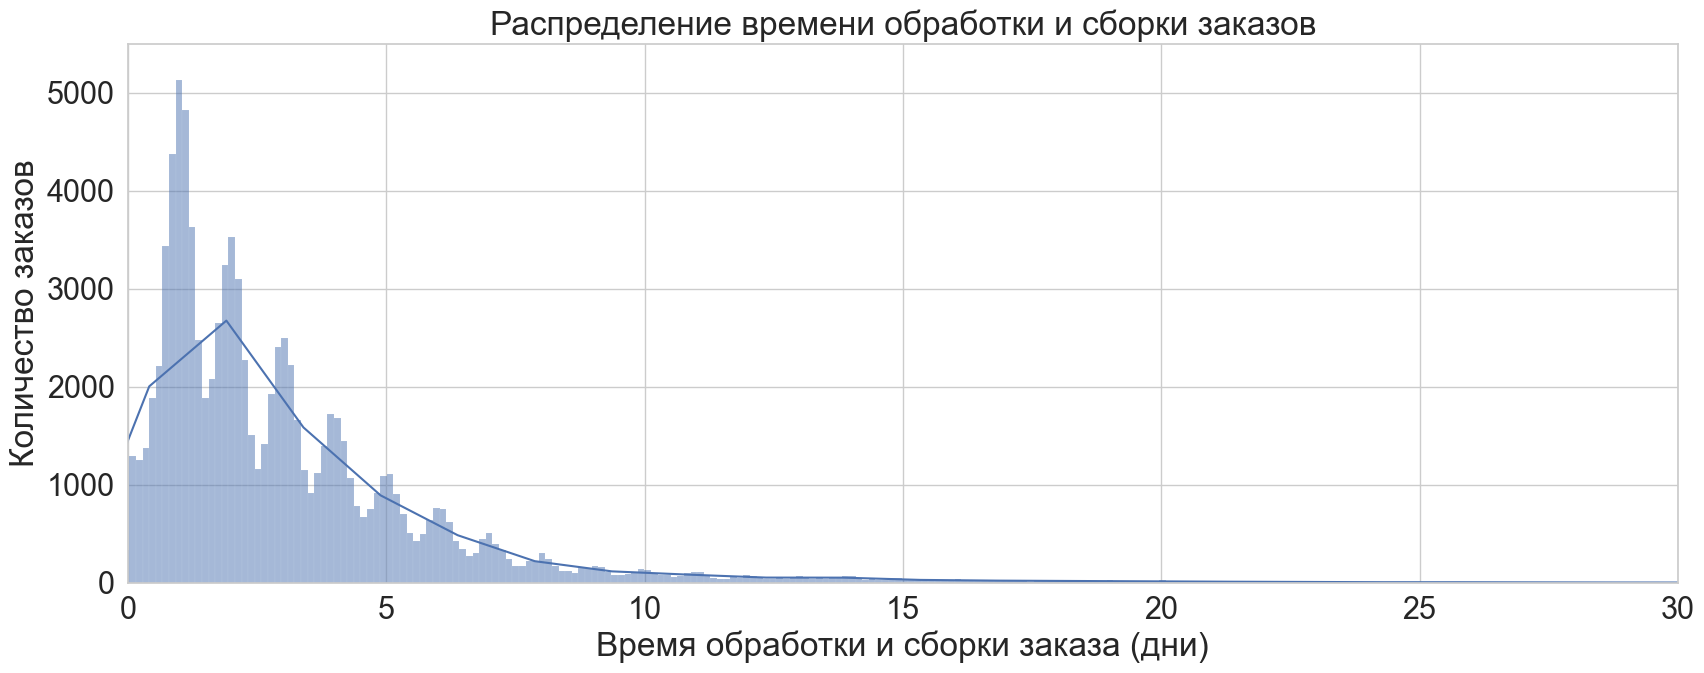

In [37]:
sns.histplot(data=df_1_full, x="processing_time", kde=True)
plt.xlim([0, 30])
plt.ylim([0, 5500])
plt.xlabel("Время обработки и сборки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение времени обработки и сборки заказов")

In [38]:
df_1_full['delivery_time'].describe()

count    96469.000000
mean         9.330297
std          8.759924
min        -16.096169
25%          4.100046
50%          7.099769
75%         12.028646
max        205.190972
Name: delivery_time, dtype: float64

Судя по описанию средний срок доставки заказа около 9-и дней, в то время как 75% заказов доставлялись около 12-и дней

Text(0.5, 1.0, 'Распределение времени доставки заказов')

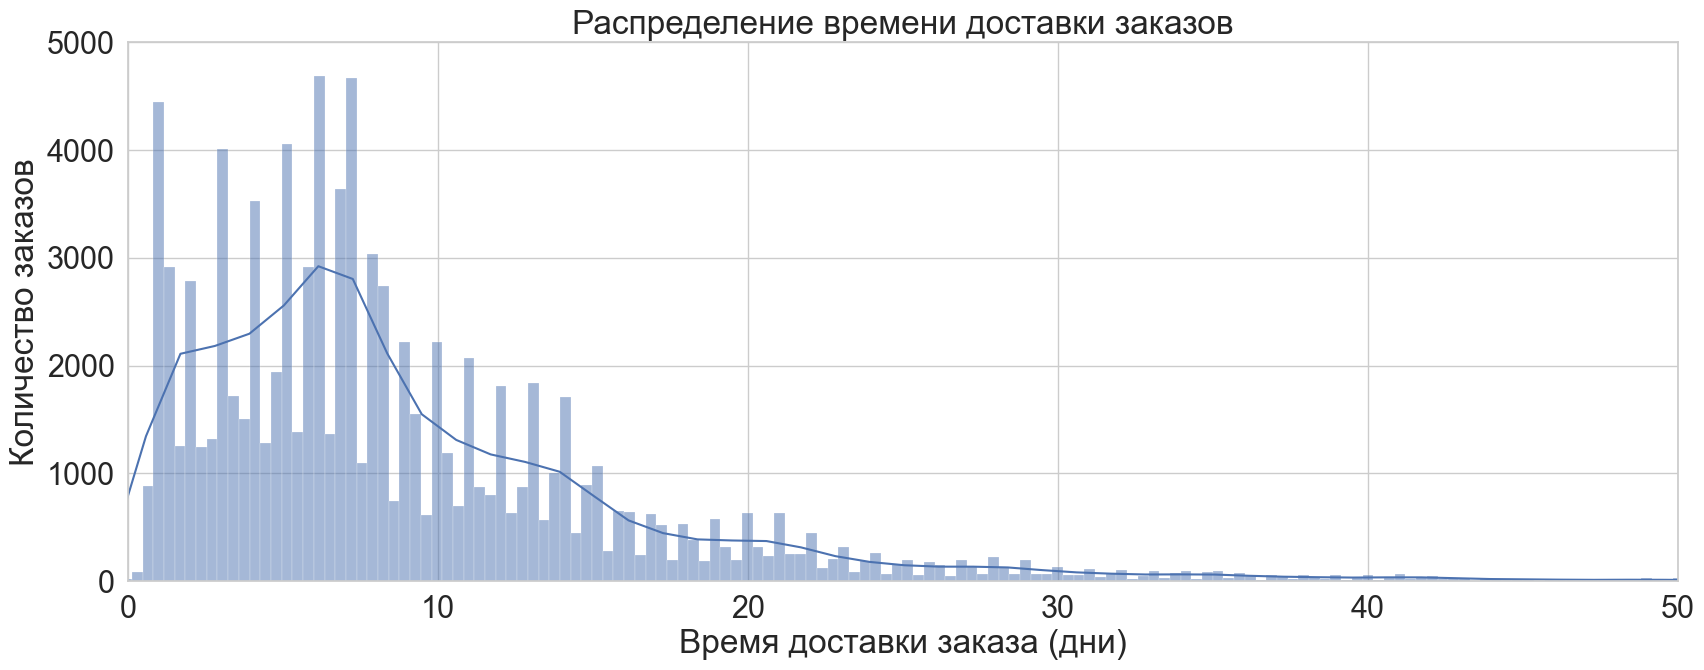

In [41]:
sns.histplot(data=df_1_full, x="delivery_time", kde=True)
plt.xlim([0, 50])
plt.ylim([0, 5000])
plt.xlabel("Время доставки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение времени доставки заказов")

In [42]:
df_1_full['delta_delivery_time'].describe()

count    96470.000000
mean       -11.178126
std         10.184354
min       -146.016123
25%        -16.244065
50%        -11.948102
75%         -6.389815
max        188.975081
Name: delta_delivery_time, dtype: float64

Судя по описанию большая часть заказов была доставлена вовремя (часть графика левее 0).

Text(0.5, 1.0, 'Распределение дней просрочки по доставке заказов')

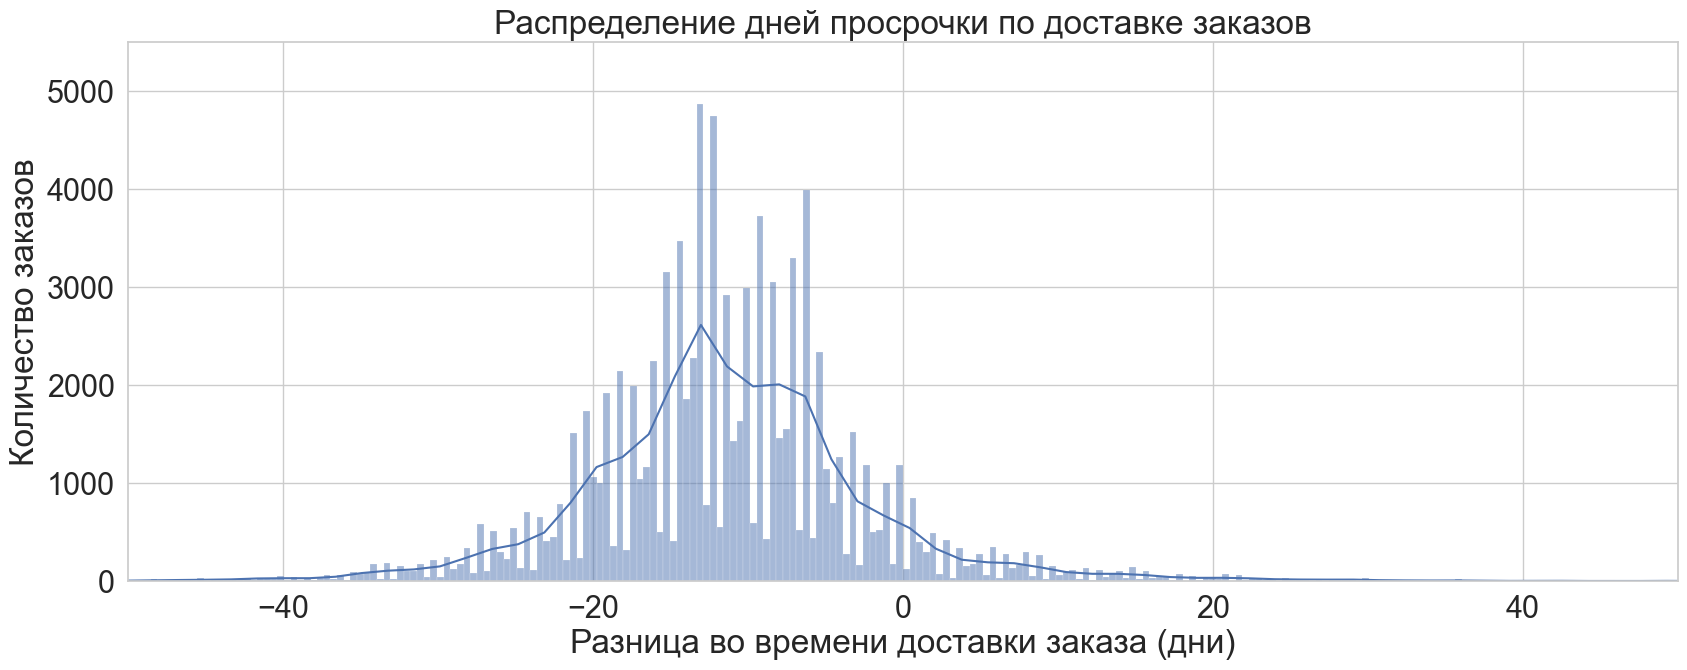

In [43]:
sns.histplot(data=df_1_full, x="delta_delivery_time", kde=True)
plt.xlim([-50, 50])
plt.ylim([0, 5500])
plt.xlabel("Разница во времени доставки заказа (дни)")
plt.ylabel("Количество заказов")
plt.title("Распределение дней просрочки по доставке заказов")

***Вывод:*** однозначно сложно сказать, почему мы теряем клиентов. Время доставки в большинстве случаев занимает меньше обещанного времени. Вероятно, потеря клиентов может быть связана с качеством самого товара, либо с качеством доставки.

### 2 вопрос. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? ###

Недоставленный заказ - заказ со статусом 'unavailable', 'canceled'. За дату доставки принимаем 'order_estimated_delivery_date'

In [44]:
# Отфильтруем необходимые нам данные со статусами 'unavailable', 'canceled'
# Добавим в датафрейм столбец с нмоером месяца
df_2 = orders.query('order_status == ["unavailable", "canceled"]')
df_2['estimated_month'] = df_2['order_estimated_delivery_date'].dt.month
df_2

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\2934964350.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,12
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,9
...,...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,2
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,10
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,9
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,9


In [45]:
# Выполняем группировку по месяцу и статусу, агрегируем по количеству заказов
# Выполняем группировку по статусу, агрегируем по среднему значению заказов в месяц
df_2.groupby(['estimated_month', 'order_status'], as_index = False)['order_id'].count()  \
    .groupby(['order_status'], as_index = False).agg({'order_id':'mean'})

,order_status,order_id
0,canceled,52.083333
1,unavailable,50.750000


In [46]:
# Выполняем группировку по месяцу и статусу, агрегируем по количеству заказов
df_2.groupby(['estimated_month', 'order_status'], as_index = False)['order_id'].count()

,estimated_month,order_status,order_id
0,1,canceled,7
1,1,unavailable,44
2,2,canceled,34
3,2,unavailable,42
4,3,canceled,114
5,3,unavailable,100
6,4,canceled,39
7,4,unavailable,30
8,5,canceled,49
9,5,unavailable,28


In [47]:
# Создадим датафрейм с сортировкой заказов по месяцам со статусом "canceled"
no_delivery_cans = df_2.query('order_status == "canceled"').groupby(['estimated_month'], as_index = False)['order_id'].count()
no_delivery_cans

,estimated_month,order_id
0,1,7
1,2,34
2,3,114
3,4,39
4,5,49
5,6,40
6,7,47
7,8,101
8,9,76
9,10,33


Text(0.5, 1.0, "Заказы со статусом 'отменен' в разрезе месяца")

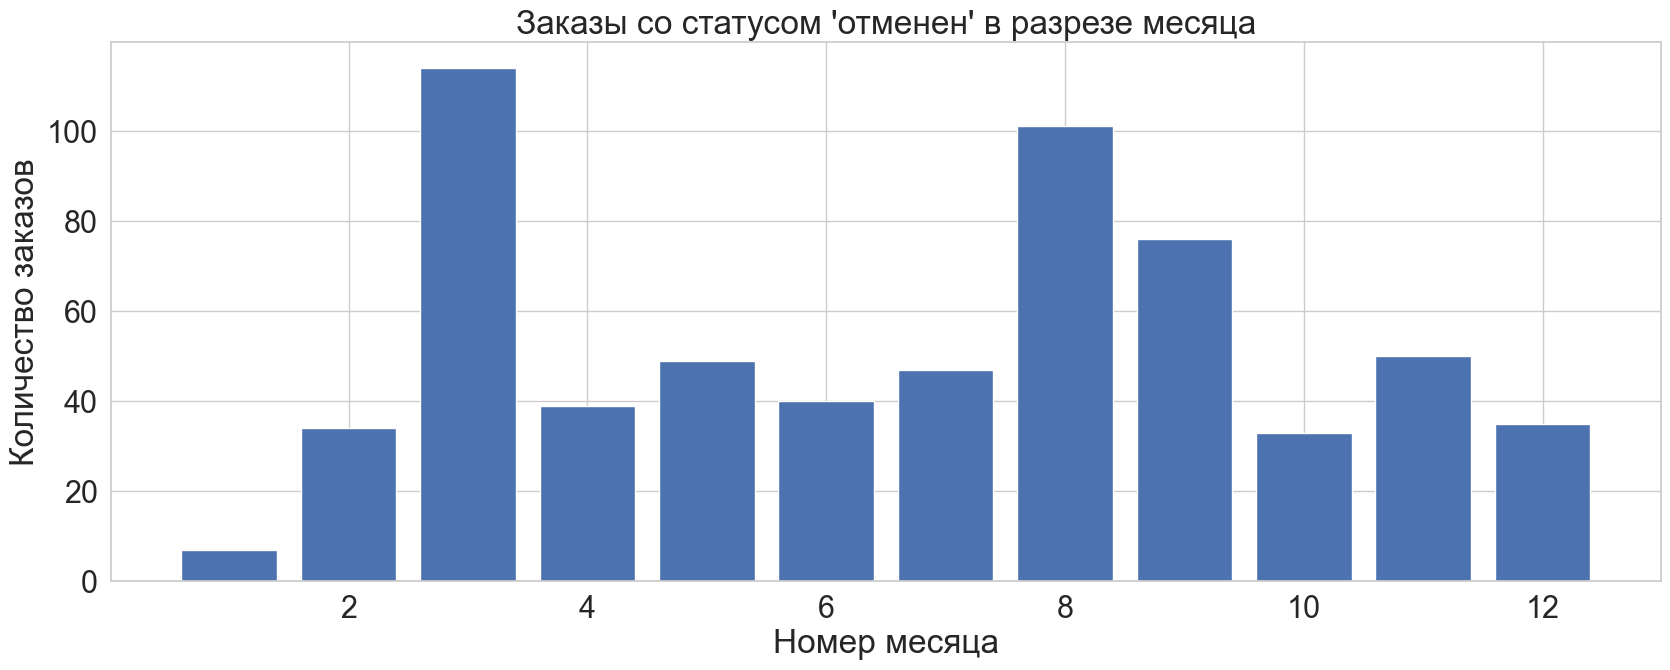

In [49]:
# Визуализируем полученные данные
plt.bar(no_delivery_cans['estimated_month'], no_delivery_cans['order_id'])
plt.xlabel("Номер месяца")
plt.ylabel("Количество заказов")
plt.title("Заказы со статусом 'отменен' в разрезе месяца")

In [50]:
# Создадим датафрейм с сортировкой заказов по месяцам со статусом "unavailable"
no_delivery_unav = df_2.query('order_status == "unavailable"').groupby(['estimated_month'], as_index = False)['order_id'].count()
no_delivery_unav

,estimated_month,order_id
0,1,44
1,2,42
2,3,100
3,4,30
4,5,28
5,6,36
6,7,41
7,8,65
8,9,35
9,10,40


Text(0.5, 1.0, "Заказы со статусом 'недоступен' в разрезе месяца")

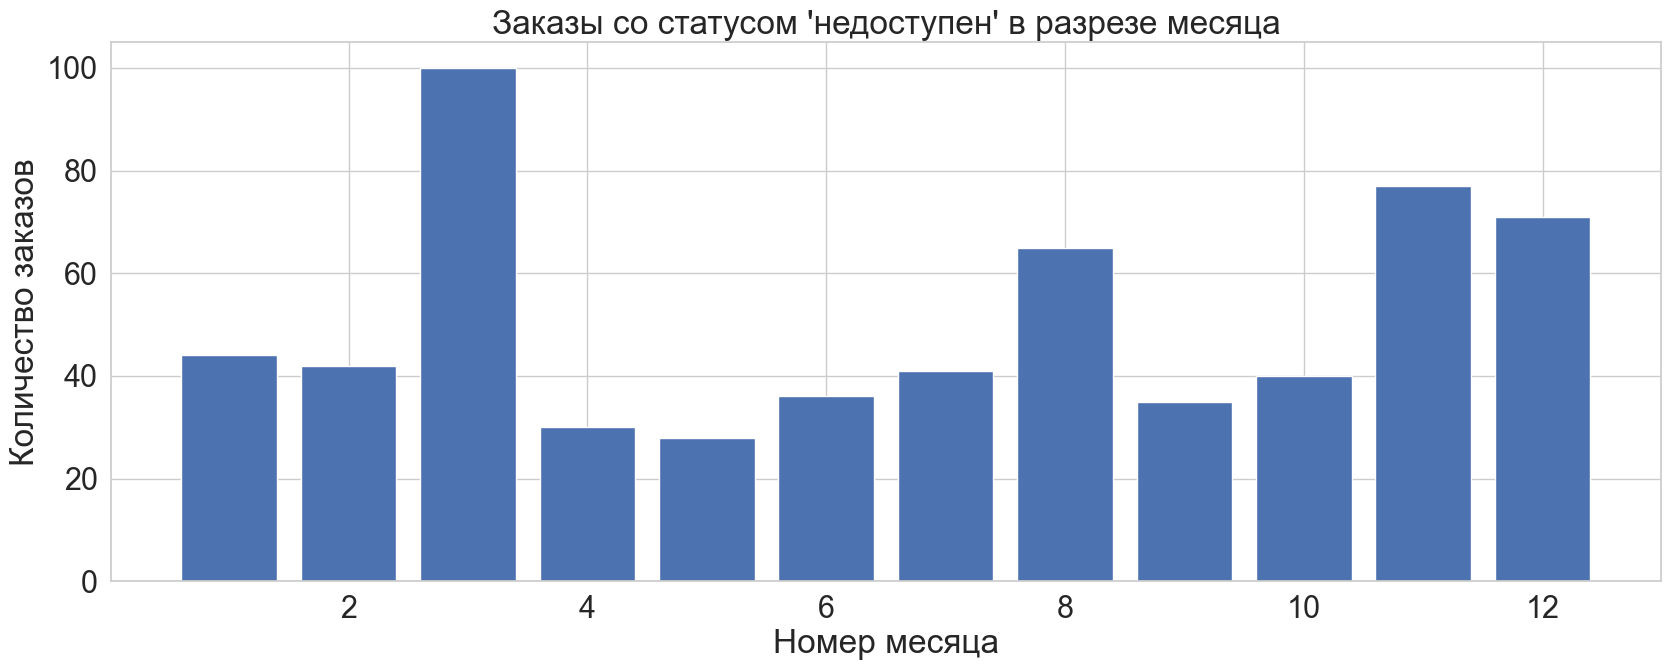

In [52]:
# Визуализируем полученные данные
plt.bar(no_delivery_unav['estimated_month'], no_delivery_unav['order_id'])
plt.xlabel("Номер месяца")
plt.ylabel("Количество заказов")
plt.title("Заказы со статусом 'недоступен' в разрезе месяца")

### 3 вопрос. По каждому товару определить, в какой день недели товар чаще всего покупается. ###

In [53]:
# Формируем необходимый нам датафрейм (объединим датасеты orders и items, чтобы понимать, какие товары заказывались покупателями)
df_3 = orders.merge(items, how='left', on='order_id')
df_3

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [54]:
# Создадим столбец с днем недели
df_3['created_day'] = df_3['order_purchase_timestamp'].dt.day_name()
df_3

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,created_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,Tuesday
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,Sunday
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday


In [55]:
# Отфильтруем датафрейм (получим необходимые нам совершенные покупки)
prod_week = df_3.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['product_id', 'created_day'], as_index = False) \
    .agg({'order_item_id':'count'}) \
    .sort_values(by = ['order_item_id', 'product_id'], ascending = False)
prod_week

,product_id,created_day,order_item_id
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40675,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40680,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


In [56]:
# Сформируем датафрейм с данными о дне, в который было продано максимальное количество каждого товара
# Объединим созданный датафрейм с датафреймом prod_week с фильтрацией
max_prod_week = prod_week.groupby('product_id')['order_item_id'].max().reset_index()
fin_prod_week = prod_week.merge(max_prod_week, on=['product_id', 'order_item_id']).sort_values(by = ['order_item_id', 'product_id'], ascending = False)
fin_prod_week

,product_id,created_day,order_item_id
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
4,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
42292,000b8f95fcb9e0096488278317764d19,Friday,1
42293,000b8f95fcb9e0096488278317764d19,Wednesday,1
42294,0009406fd7479715e4bef61dd91f2462,Thursday,1
42295,00088930e925c41fd95ebfe695fd2655,Tuesday,1


Мы получили данные о максимальном количестве покупок товара по дням. Отметим, что если товар продавался не более 1-го раза в различные дни недели, то наименование такого товара встречается N раз (N - количество дней, в которые этот товар продавался).

Для наглядности построим диаграмму, которая показывает, в какие дни клиенты чаще покупают товары.

Text(0.5, 1.0, 'Максимальные продажи товаров по дням недели')

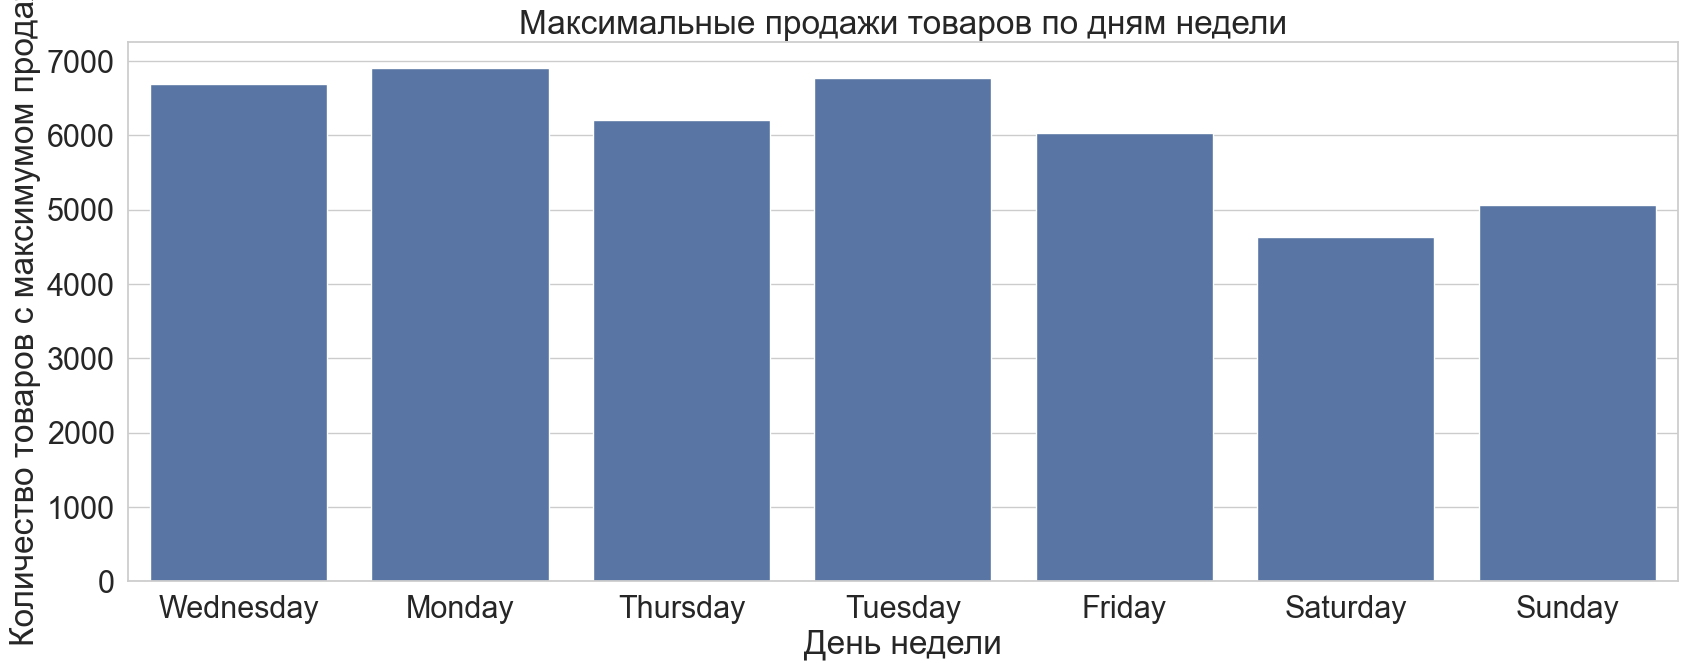

In [59]:
sns.countplot(x='created_day', data=fin_prod_week)
plt.xlabel("День недели")
plt.ylabel("Количество товаров с максимумом продаж")
plt.title("Максимальные продажи товаров по дням недели")

Исходя из этого графика можно сделать вывод, что чаще всего люди покупают товары в начале недели. К концу недели покупатели менее активные. 

Теперь можем посмотреть на суммарное количество покупаемых товаров по дням.

In [58]:
sum_prod_week = prod_week.groupby(['created_day'], as_index = False).agg({'order_item_id':'sum'})
sum_prod_week

,created_day,order_item_id
0,Friday,15936
1,Monday,18227
2,Saturday,12072
3,Sunday,13318
4,Thursday,16639
5,Tuesday,18070
6,Wednesday,17477


Text(0.5, 1.0, 'Количесвто проданных товаров по дням недели')

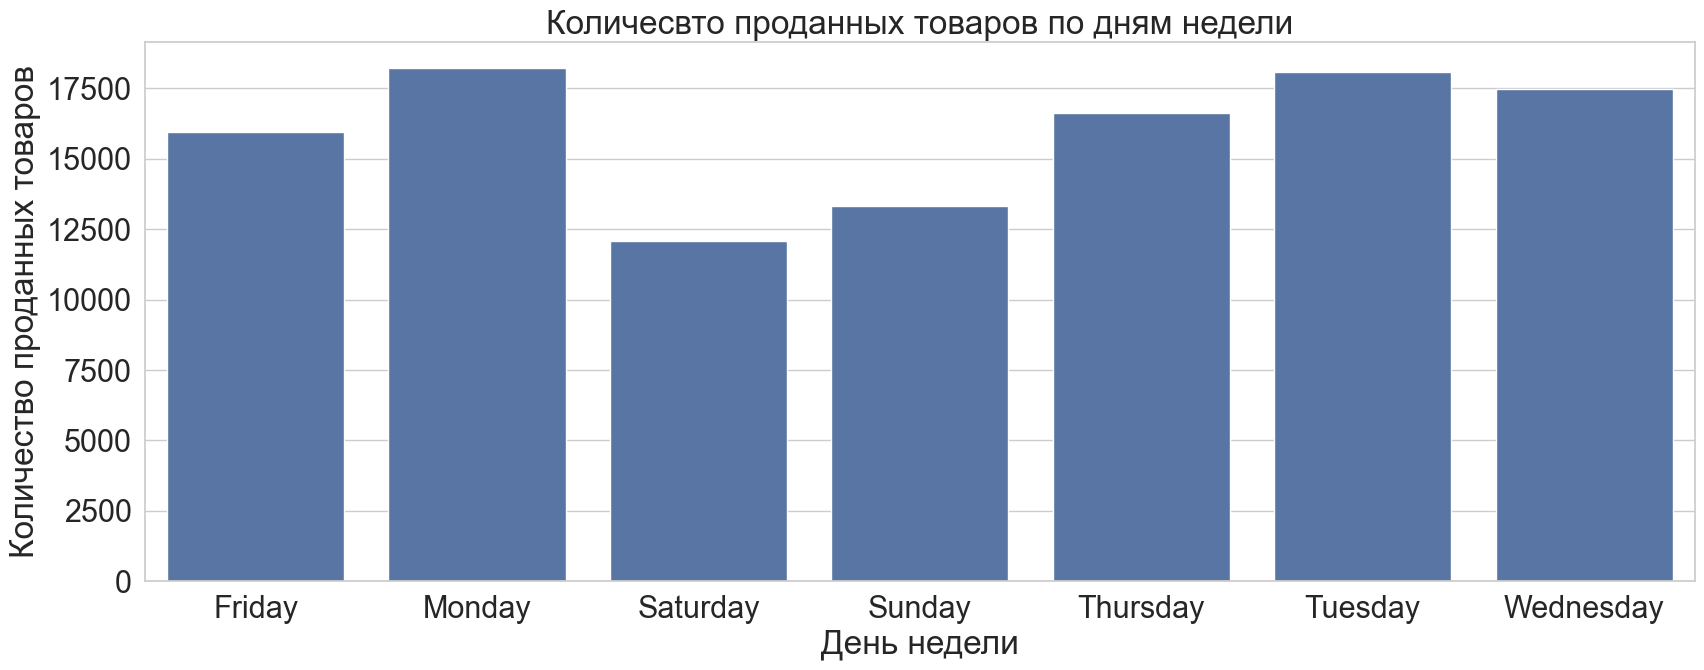

In [60]:
sns.barplot(x='created_day', y='order_item_id', data=sum_prod_week)
plt.xlabel("День недели")
plt.ylabel("Количество проданных товаров")
plt.title("Количесвто проданных товаров по дням недели")

Снова можно сделать вывод, что больше всего люди покупают товаров в начале недели. К концу недели покупатели заказывают меньшее количество товаров.

Отметим, что если снижение активности клиентов в выходные дни - проблема для нас -> нужно попытаться решить ее. Возможно, рассмотреть различные варианты стимулирвоания активности покупателей в выходные дни

### 4 вопрос. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. ###

In [61]:
# Функция для расчета количества недель в месяце
def weeks_in_month(date):
    days_in_month = (date + pd.offsets.MonthEnd(0)).day
    full_weeks = days_in_month / 7
    full_weeks = round(full_weeks, 2)
    return full_weeks

In [62]:
# Формируем необходимый нам датафрейм (объединим датасеты orders и customers, чтобы понимать, какие покупатели заказывали товары)
df_4 = orders.merge(customers, how='left', on='customer_id')

In [63]:
# Сформируем столбец с датой покупки в формате Y-M
# Расчет количества недель
df_4['created_year_month'] = df_4['order_purchase_timestamp'].dt.to_period('M')
df_4['weeks'] = df_4['order_purchase_timestamp'].apply(weeks_in_month)
df_4

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,created_year_month,weeks
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,4.43
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,4.43
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,4.43
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,4.29
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03,4.43
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02,4.00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08,4.43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01,4.43


In [64]:
cust_month = df_4.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['customer_unique_id', 'created_year_month', 'weeks'], as_index = False) \
    .agg({'order_status':'count'}) \
    .sort_values(by = 'created_year_month')
cust_month

,customer_unique_id,created_year_month,weeks,order_status
69434,b7d76e111c89f7ebf14761390f0f7d17,2016-09,4.29,1
49541,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,4.29,1
94025,f922896769e9517ea3c630f3c8de86d0,2016-10,4.43,1
7692,14359ea0c7a105749c0a56478825b015,2016-10,4.43,1
1166,0313291a6f4f16df04dcf819d88c38ef,2016-10,4.43,1
...,...,...,...,...
50610,8616838509a6c7181b26db78dec86e46,2018-08,4.43,1
36,001928b561575b2821c92254a2327d06,2018-08,4.43,1
96512,ffe204b1bb8026741b839085b2fd10f2,2018-08,4.43,1
63884,a917c56ddf872625b041ef6521cd06a9,2018-08,4.43,1


In [65]:
cust_month['mean_week'] = cust_month['order_status'] / cust_month['weeks']
cust_month.sort_values(by = 'mean_week', ascending = False)

,customer_unique_id,created_year_month,weeks,order_status,mean_week
7214,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.43,6,1.354402
68340,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.00,4,1.000000
23576,3e43e6105506432c953e165fb2acf44c,2018-02,4.00,4,1.000000
61252,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.00,4,1.000000
14263,25a560b9a6006157838aab1bdbd68624,2017-04,4.29,4,0.932401
...,...,...,...,...,...
60438,a001dad8726d7eadddb0142d138d1cbb,2018-08,4.43,1,0.225734
32412,55b9662183a72ec77b8f467ff8d42fa3,2016-10,4.43,1,0.225734
47009,7c6157bc4c2bae550d37b6fc445db0d5,2016-10,4.43,1,0.225734
65545,ad7f0d20b46f7386fa4509cbd19c095d,2016-10,4.43,1,0.225734


Таким образом, максимальное среднее количество покупок в неделю составило 1,35 в январе 2017 года. В данном случае 1 покупка - 1 заказ.

### 5 вопрос. Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. ###

Нам необходимо оценить **retention**, т.е. оценить, продолжают ли люди пользоваться нашим продуктом снова и снова, находят ли они в нем достаточную ценность для решения своих задач. По условию задачи нам необходимо выявить, когда доля людей, вернувшихся на третий месяц, будет максимальная (в период с января по декабрь).
Учитывая, что данные должны быть с января по декабрь - проанализируем, какие данные у нас имеются.

In [66]:
orders['order_purchase_timestamp'].dt.to_period('M').unique()

<PeriodArray>
['2017-10', '2018-07', '2018-08', '2017-11', '2018-02', '2017-07', '2017-04',
 '2017-05', '2017-01', '2018-06', '2018-03', '2018-01', '2017-12', '2017-09',
 '2018-05', '2017-08', '2018-04', '2017-03', '2017-06', '2017-02', '2016-10',
 '2018-09', '2016-09', '2018-10', '2016-12']
Length: 25, dtype: period[M]

За 2016 год - данные за сент, окт, дек;
За 2017 год - данные за весь год;
За 2018 год - данные за янв-окт
Таким образом мы можем провести когортный анализ за период **янв 2017 - декабрь 2017**.

In [67]:
# Формируем необходимый нам датафрейм (объединим датасеты orders и customers, чтобы понимать, какие покупатели заказывали товары)
# Фильтруем необходимые нам ПОКУПКИ 2017 года
df_5 = orders.merge(customers, how='left', on='customer_id')
df_5 = df_5.query('order_status == ["processing", "shipped", "delivered"]')[df_5['order_purchase_timestamp'].dt.year == 2017]
df_5

C:\Users\m.luchnikov\AppData\Local\Temp\ipykernel_12860\1986215438.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS
...,...,...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP


In [68]:
first = df_5.sort_values(by='order_purchase_timestamp').drop_duplicates(subset='customer_unique_id')
first

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
78768,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR
16201,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR
74670,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR
49750,34bf4feda1e203af64692d97c6950c39,64b56cb1662271f54a81d96a28741487,delivered,2017-01-05 12:14:58,2017-01-07 03:35:24,2017-01-11 16:09:04,2017-01-16 16:13:55,2017-02-01,da9c90677b1963eca1cf8a14c338cf6e,80220,curitiba,PR
85120,40599d3d28b75746952ded75566637b9,efdf4a7c78d7c364046efb69035d1d4f,delivered,2017-01-05 13:01:48,2017-01-07 03:45:49,2017-01-11 16:08:53,2017-01-16 15:43:21,2017-02-13,ef89f6e31311594d74becf9e18c73693,80030,curitiba,PR
...,...,...,...,...,...,...,...,...,...,...,...,...
63676,60d98124c3228470422ecadff6550e3c,98a1a1e41310f70974831b79bf01e4e6,delivered,2017-12-31 21:10:02,2017-12-31 21:26:47,2018-01-02 15:08:20,2018-01-05 18:51:54,2018-01-18,e6797b7d4c35624ef13982ab27d3255b,4140,sao paulo,SP
83731,43e38490d21c8c490334f75c5a7c2861,2f368064b4e6646a7784a46b03b4bcbc,delivered,2017-12-31 21:17:54,2017-12-31 21:27:24,2018-01-02 20:17:58,2018-01-05 17:59:20,2018-02-01,addd42012ed67639f9e0d26155b7c2e1,4126,sao paulo,SP
48450,18f39cbc016f34a22c870ef03cba5641,92566e623b70efba98063150b200cba4,delivered,2017-12-31 22:14:53,2017-12-31 22:26:35,2018-01-02 18:35:39,2018-01-22 22:57:47,2018-01-31,b890928f02ba9a0dfbc6ec8009bee0fd,74290,goiania,GO
39981,8acda261d8c76b3206d9cb5279d0a18a,dc3daad47c0792f3bd4366246a7955dc,delivered,2017-12-31 23:24:10,2017-12-31 23:32:40,2018-01-04 11:15:57,2018-01-23 22:37:13,2018-02-08,5d11f19985edbb3c068e805434a80f87,95820,general camara,RS


In [69]:
# Сформируем столбец с датой покупки в формате Y-M
first['first_date'] = first['order_purchase_timestamp']
first['first_month'] = first['order_purchase_timestamp'].dt.to_period('M')
first

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_date,first_month
78768,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,2017-01-05 11:56:06,2017-01
16201,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR,2017-01-05 12:01:20,2017-01
74670,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,2017-01-05 12:06:36,2017-01
49750,34bf4feda1e203af64692d97c6950c39,64b56cb1662271f54a81d96a28741487,delivered,2017-01-05 12:14:58,2017-01-07 03:35:24,2017-01-11 16:09:04,2017-01-16 16:13:55,2017-02-01,da9c90677b1963eca1cf8a14c338cf6e,80220,curitiba,PR,2017-01-05 12:14:58,2017-01
85120,40599d3d28b75746952ded75566637b9,efdf4a7c78d7c364046efb69035d1d4f,delivered,2017-01-05 13:01:48,2017-01-07 03:45:49,2017-01-11 16:08:53,2017-01-16 15:43:21,2017-02-13,ef89f6e31311594d74becf9e18c73693,80030,curitiba,PR,2017-01-05 13:01:48,2017-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63676,60d98124c3228470422ecadff6550e3c,98a1a1e41310f70974831b79bf01e4e6,delivered,2017-12-31 21:10:02,2017-12-31 21:26:47,2018-01-02 15:08:20,2018-01-05 18:51:54,2018-01-18,e6797b7d4c35624ef13982ab27d3255b,4140,sao paulo,SP,2017-12-31 21:10:02,2017-12
83731,43e38490d21c8c490334f75c5a7c2861,2f368064b4e6646a7784a46b03b4bcbc,delivered,2017-12-31 21:17:54,2017-12-31 21:27:24,2018-01-02 20:17:58,2018-01-05 17:59:20,2018-02-01,addd42012ed67639f9e0d26155b7c2e1,4126,sao paulo,SP,2017-12-31 21:17:54,2017-12
48450,18f39cbc016f34a22c870ef03cba5641,92566e623b70efba98063150b200cba4,delivered,2017-12-31 22:14:53,2017-12-31 22:26:35,2018-01-02 18:35:39,2018-01-22 22:57:47,2018-01-31,b890928f02ba9a0dfbc6ec8009bee0fd,74290,goiania,GO,2017-12-31 22:14:53,2017-12
39981,8acda261d8c76b3206d9cb5279d0a18a,dc3daad47c0792f3bd4366246a7955dc,delivered,2017-12-31 23:24:10,2017-12-31 23:32:40,2018-01-04 11:15:57,2018-01-23 22:37:13,2018-02-08,5d11f19985edbb3c068e805434a80f87,95820,general camara,RS,2017-12-31 23:24:10,2017-12


In [70]:
# Объединяем датасеты df_5 и first так, чтобы для каждого заказа мы видели в стоолбце created_month - дату первого заказа для этого покупателя
all_orders_2017 = df_5.merge(first[['customer_unique_id','first_date', 'first_month']], on='customer_unique_id', how='left')
all_orders_2017

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_date,first_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-04 11:26:38,2017-09
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-18 19:28:06,2017-11
2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-09 21:57:05,2017-07
3,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-16 13:10:30,2017-05
4,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017-01-23 18:29:09,2017-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44193,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-04 19:57:37,2017-10
44194,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-27 00:30:03,2017-01
44195,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-23 09:05:12,2017-02
44196,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-09 09:54:05,2017-03


In [71]:
all_orders_2017['cog_period'] = all_orders_2017['order_purchase_timestamp'].dt.month - all_orders_2017['first_month'].dt.month
all_orders_2017

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_date,first_month,cog_period
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-04 11:26:38,2017-09,1
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-18 19:28:06,2017-11,0
2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-09 21:57:05,2017-07,0
3,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-16 13:10:30,2017-05,0
4,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017-01-23 18:29:09,2017-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44193,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-04 19:57:37,2017-10,0
44194,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-27 00:30:03,2017-01,0
44195,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-23 09:05:12,2017-02,0
44196,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-09 09:54:05,2017-03,0


In [72]:
final = all_orders_2017.groupby(['first_month', 'cog_period'], as_index = False) \
    .agg({'order_id':'count'})
final

,first_month,cog_period,order_id
0,2017-01,0,775
1,2017-01,1,3
2,2017-01,2,2
3,2017-01,3,1
4,2017-01,4,3
...,...,...,...
72,2017-10,1,33
73,2017-10,2,11
74,2017-11,0,7257
75,2017-11,1,42


In [73]:
final = final.reset_index().set_index(['cog_period', 'first_month'])['order_id'].unstack(0)
final

cog_period,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-01,775.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1703.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2608.0,14.0,9.0,12.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2342.0,15.0,6.0,5.0,7.0,6.0,9.0,7.0,7.0,NaN,NaN,NaN
2017-05,3595.0,18.0,18.0,14.0,11.0,14.0,17.0,5.0,NaN,NaN,NaN,NaN
2017-06,3150.0,14.0,12.0,12.0,8.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3888.0,22.0,13.0,9.0,13.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4188.0,29.0,16.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# final = final.pivot(index='first_month', columns='cog_period', values='order_id') \
#     .reset_index()
# final

In [75]:
# col = final.columns[2:]
# for i in col:
#     final[i] = final[i]/final[0]
# final

In [76]:
# Считаю retention

final = final.divide(final[0], axis=0)
final

cog_period,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-01,1.0,0.003871,0.002581,0.001290,0.003871,0.001290,0.003871,0.001290,0.001290,NaN,0.003871,0.00129
2017-02,1.0,0.002349,0.002936,0.001174,0.004110,0.001174,0.002349,0.001762,0.001174,0.001762,0.001174,NaN
2017-03,1.0,0.005368,0.003451,0.004601,0.003451,0.001534,0.001534,0.003067,0.003451,0.000767,NaN,NaN
2017-04,1.0,0.006405,0.002562,0.002135,0.002989,0.002562,0.003843,0.002989,0.002989,NaN,NaN,NaN
2017-05,1.0,0.005007,0.005007,0.003894,0.003060,0.003894,0.004729,0.001391,NaN,NaN,NaN,NaN
2017-06,1.0,0.004444,0.003810,0.003810,0.002540,0.003492,0.003492,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005658,0.003344,0.002315,0.003344,0.002058,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006925,0.003820,0.002627,0.003582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006778,0.005326,0.003873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


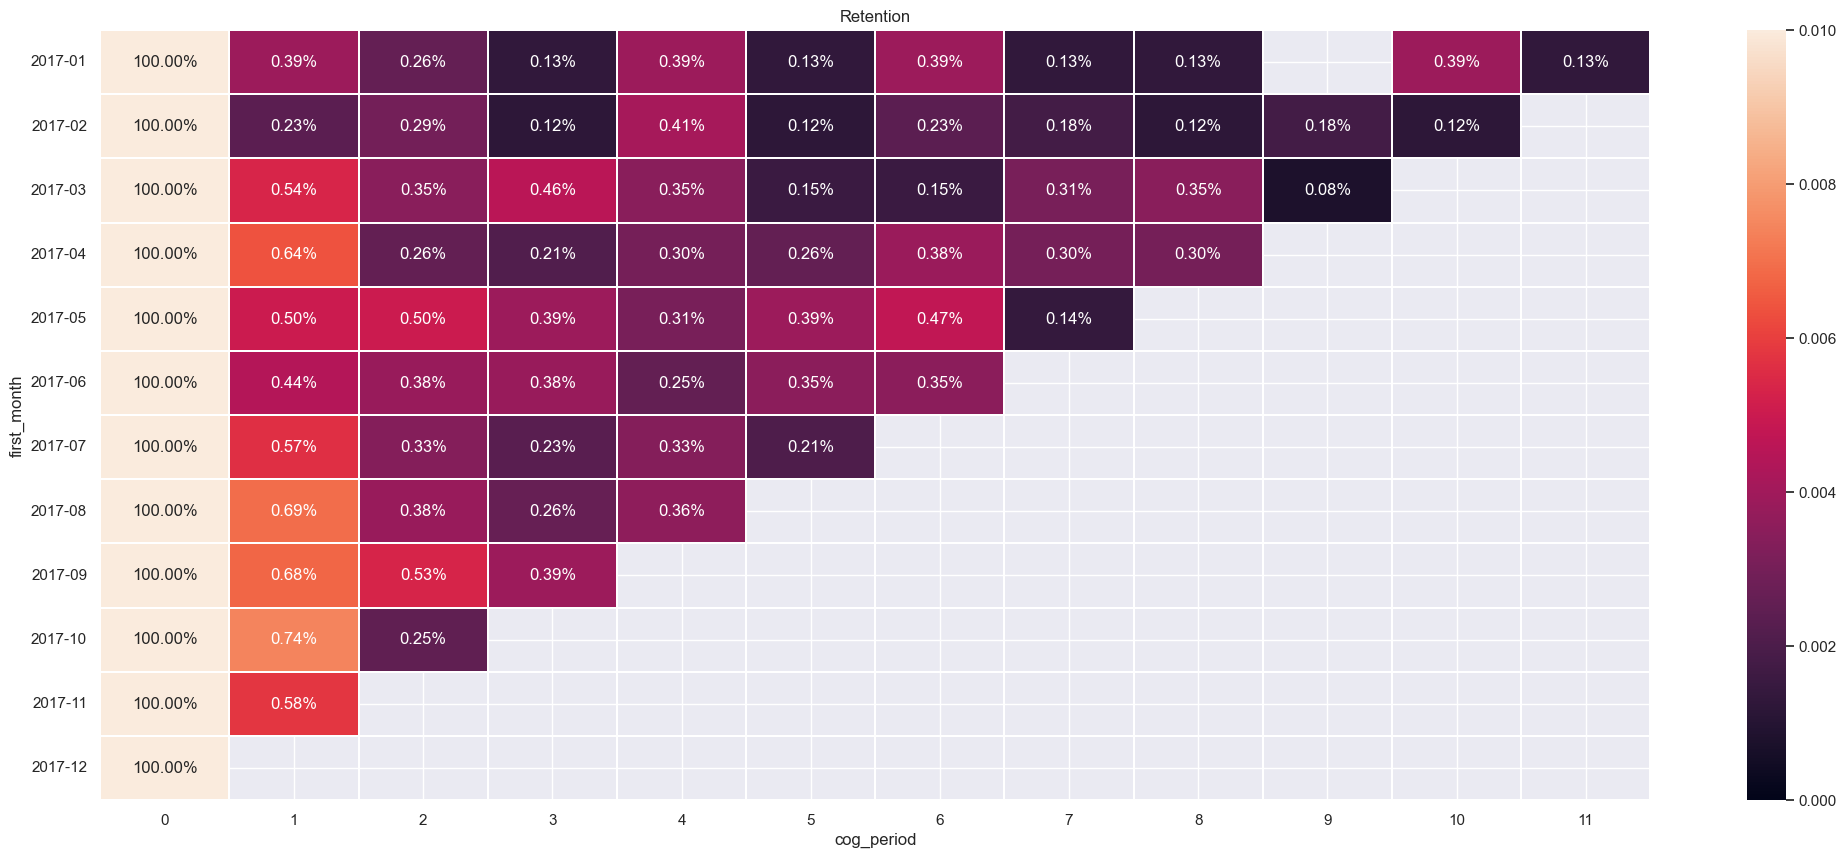

In [78]:
sns.set(rc={"figure.figsize": (25, 10)})
plt.title('Retention')
sns.heatmap(final, mask=final.isnull(), annot=True, fmt='.2%', linewidth=.3, vmin=0, vmax=0.01)
plt.yticks(rotation=0)
plt.show()

Самый высокий Retention за третий месяц у пользователей, которые совершили первую покупку в **марте** - он составляет **0,46 %**

### 6 вопрос. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. ###

Нам необходимо построить RFM - сегментацию пользователей. Для начала нужно оценить, в каких пределах меняются показатели метрик: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [79]:
# Формируем необходимый нам датафрейм
# Оставляем только покупки
# Убираем строки с пустым данными
df_6 = orders.merge(customers, how='left', on='customer_id')
df_6 = df_6.merge(items, how='left', on='order_id')
df_6 = df_6.query('order_status == ["processing", "shipped", "delivered"]').dropna()
df_6

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [80]:
# Для наглядности эксперимента зададимся сегодняшней "условной" = следующий день после даты последнего заказа
today = df_6.order_purchase_timestamp.max() + timedelta(days=1)
today


Timestamp('2018-08-30 15:00:37')

In [81]:
# Сформируем датафрейм с нашими метриками R, F, M
RFM = df_6.groupby('customer_unique_id', as_index = False) \
             .agg({'order_purchase_timestamp': lambda x:(today - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
             .rename(columns = {'order_purchase_timestamp': 'R', 'order_id': 'F', 'price': 'M'})
RFM

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Для классификации пользователей по кластерам - исползуем квантили 0.2, 0.4, 0.6, 0.8

In [82]:
quintiles = RFM[['R', 'F', 'M']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'R': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'F': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'M': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [83]:
# Посмотрим на минимальные и максиальные значения метрик
RFM.describe()

,R,F,M
count,93336.000000,93336.000000,93336.000000
mean,237.903853,1.180391,141.621663
std,152.552964,0.620913,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,24.000000,13440.000000


**Параметры метрик**

**R (давность)** - время от последней покупки покупателя до текущей даты:
- 1 - > 1 года
- 2 - от 6 месяцев до 1 года
- 3 - от 1 до 6 месяцев
- 4 - < 1 месяца
Чем выше оценка, тер меньше срок от последней покупки

**F (частота)** -  количество покупок у покупателя за всё время:
- 1 - <=1 покупка
- 2 - 1-4 покупки
- 3 - 4-6 покупок
- 4 - >= 6 покупок


**M (денежная ценность)** - сумма всех покупок
- 1 - < 40
- 2 - 40-110
- 3 - 110-180
- 4 - > 180
Чем выше оценка, тем больше сумма. использовали значения квантилей

In [84]:
# Разделим на сегменты метрики
RFM['R_ceg'] = pd.cut(RFM.R, bins = [0, 30, 180, 365, 730], labels = ['4', '3', '2', '1']).astype(str)
RFM['F_ceg'] = pd.cut(RFM.F, bins = [0, 1, 4, 6, 25], labels = ['1', '2', '3', '4']).astype(str)
RFM['M_ceg'] = pd.cut(RFM.M, bins = [0, 40, 110, 180, 13450], labels = ['1', '2', '3', '4']).astype(str)

# формирую показатель RFM
RFM['RFM'] = RFM['R_ceg'] + RFM['F_ceg'] + RFM['M_ceg']
RFM

,customer_unique_id,R,F,M,R_ceg,F_ceg,M_ceg,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,3,213
...,...,...,...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,1,2,4,124
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,2,212
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,2,112
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00,3,1,3,313


In [85]:
#  Найдем процентное содержание пользователей в зависимости от показателя RFM
RFM_per = RFM.groupby(['RFM'], as_index = False) \
    .agg({'customer_unique_id':'count'}) \
    .sort_values(by = 'customer_unique_id', ascending = False) 
RFM_per['RFM_per'] = round((RFM_per['customer_unique_id'] / RFM_per['customer_unique_id'].sum()*100), 2)
RFM_per

,RFM,customer_unique_id,RFM_per
17,212,12497,13.39
30,312,10746,11.51
1,112,7580,8.12
16,211,7068,7.57
29,311,6352,6.81
31,313,5616,6.02
18,213,5607,6.01
19,214,4976,5.33
32,314,4610,4.94
0,111,4469,4.79


Text(0.5, 1.0, 'Процентное содержание пользователей в зависимости от показателя RFM')

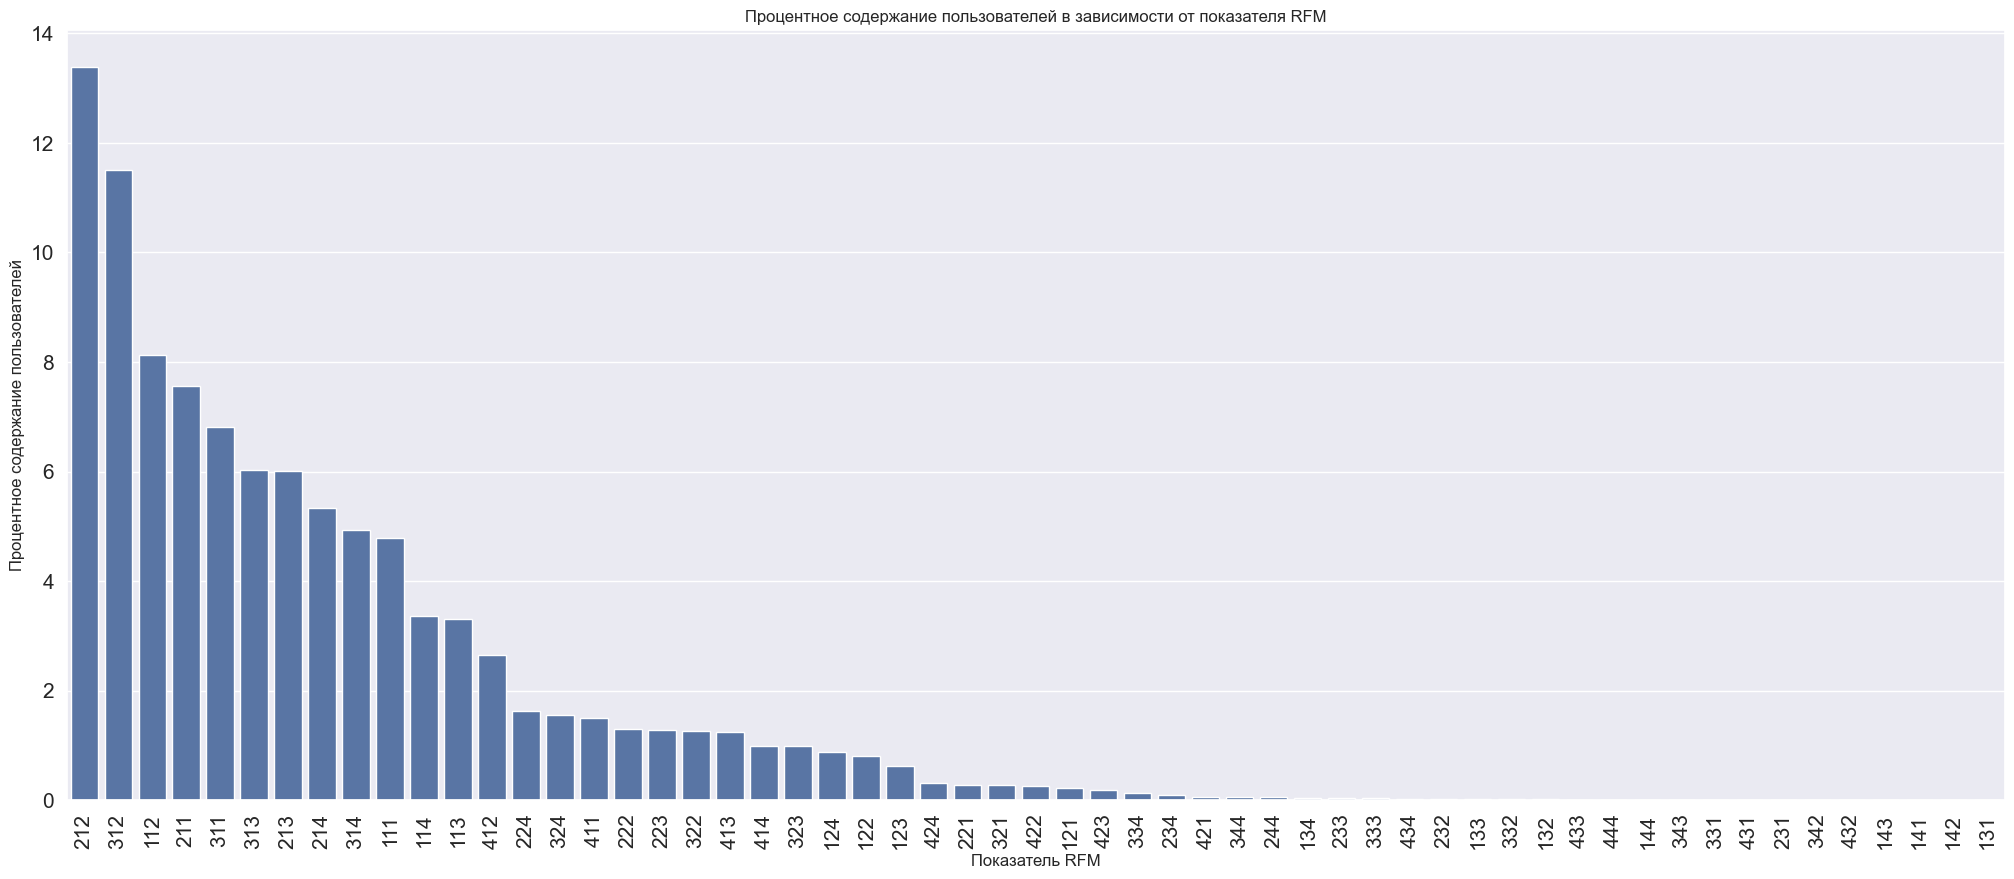

In [87]:
# Отобразим в виде графика
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xticks(rotation=90)
sns.barplot(data = RFM_per, x = 'RFM', y = 'RFM_per')
plt.xlabel("Показатель RFM")
plt.ylabel("Процентное содержание пользователей")
plt.title("Процентное содержание пользователей в зависимости от показателя RFM")

Больше всего пользователей (Более 10%) с RFM 212 и 312. Это пользователи, которые соврешили не более 1 покупки на сумму 40-110. Пользователи из первой группы совершили последнюю покупку не более полугода назад (1-6 месяцев), из второй не более года назад (6-12 месяцев).